Simple demo use of GeoWeb data

In [1]:
# developed in Python 3
!python --version

Python 3.12.4


# Initialization

In [2]:
# these modules are used in 
# geo-web-method geo-web-demo geo-web-results
!pip install -r requirements.txt --disable-pip-version-check | tail -n 5

In [3]:
import json,copy,random,operator,sys,os,re

import numpy as np
import pandas as pd
import shapely as sh
import humanize as hm
import geopandas as gpd
import matplotlib.pyplot as plt

import geonamescache as gn
gn_cache = gn.GeonamesCache()

import folium
from IPython.display import HTML
from IPython.display import Image

import requests
from bs4 import BeautifulSoup

from requests_ratelimiter import LimiterSession
session = LimiterSession(per_second=1)
session.headers.update({'User-Agent': 'geo-web','email':'utko@vut.cz'})

from tqdm import tqdm
tqdm.pandas(file=sys.stdout,ncols=100)

# Load data

In [4]:
data = pd.read_parquet('geo-web-results/geo-web-CZ.parquet')

# memory
data = data.astype({
    'web': pd.StringDtype('pyarrow'),
    'online': pd.StringDtype('pyarrow'),
    'lat': pd.StringDtype('pyarrow'),
    'lon': pd.StringDtype('pyarrow')
})

data

,web,lat,lon,city,country,online
0,https://www.ds-benesov.cz/vyrocni-zpravy/,49.7838225,14.6936618,Benešov,CZ,20230312200348
1,https://www.ds-benesov.cz/ostatni/tesime-se-na/,49.7838225,14.6936618,Benešov,CZ,20230312200348
2,https://www.ds-benesov.cz/poskytovane-cinnosti/,49.7838225,14.6936618,Benešov,CZ,20230312200348
3,https://www.ds-benesov.cz/poskytovane-cinnosti...,49.7838225,14.6936618,Benešov,CZ,20230312200348
4,https://www.ds-benesov.cz/poskytovane-cinnosti...,49.7838225,14.6936618,Benešov,CZ,20230207210724
...,...,...,...,...,...,...
112760,http://www.kaple.cz/historie/,49.5831816,15.9356752,Žďár nad Sázavou,CZ,20240518065434
112761,http://www.kaple.cz/galerie/nggallery/page/2/,49.5831816,15.9356752,Žďár nad Sázavou,CZ,20240228121457
112762,http://www.kaple.cz/galerie/,49.5831816,15.9356752,Žďár nad Sázavou,CZ,20230529094445
112763,http://www.kaple.cz/novinky/,49.5831816,15.9356752,Žďár nad Sázavou,CZ,20230322123851


In [5]:
# sampe record
data.sample(1,random_state=0).to_dict(orient='records')

[{'web': 'https://www.hospic-most.cz/pacienti/',
  'lat': '50.5088942',
  'lon': '13.6228219',
  'city': 'Most',
  'country': 'CZ',
  'online': '20230401050753'}]

# Filter by spatial polygon

In [6]:
# convert coordinates
data['crd'] = gpd.points_from_xy(data.lon,data.lat)
data = gpd.GeoDataFrame(data)
data.crd = data.crd.set_crs('EPSG:4326')

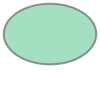

In [7]:
# define spatial polygon - circle 2km around city centre
city_centre = [49.195278,16.608333]
poly = sh.Point(city_centre[1],city_centre[0]) # reverse lat lon
poly = gpd.GeoSeries(poly).set_crs('EPSG:4326')
utm = poly.estimate_utm_crs()
poly = gpd.GeoSeries(poly).to_crs(utm)
poly = poly.buffer(2000)
poly = gpd.GeoSeries(poly).to_crs('EPSG:4326')
poly[0]

In [8]:
# filter by spatial polygon
data_poly = data.loc[data.crd.within(poly[0])]
data_poly

,web,lat,lon,city,country,online,crd
1278,https://www.centrumdvorak.cz/wp-content/themes...,49.1932205,16.6108642,Brno,CZ,20230117154740,POINT (16.61086 49.19322)
1279,https://www.centrumdvorak.cz/wp-content/themes...,49.1932205,16.6108642,Brno,CZ,20230117154740,POINT (16.61086 49.19322)
1280,https://www.centrumdvorak.cz/wp-content/themes...,49.1932205,16.6108642,Brno,CZ,20230117154740,POINT (16.61086 49.19322)
1281,https://www.centrumdvorak.cz/wp-includes/js/co...,49.1932205,16.6108642,Brno,CZ,20230117154803,POINT (16.61086 49.19322)
1295,https://centrumdvorak.cz/poskytovane-sluzby/pr...,49.1932205,16.6108642,Brno,CZ,20231209080751,POINT (16.61086 49.19322)
...,...,...,...,...,...,...,...
18220,https://www.zikron.cz/inpage/kontakt/,49.1836618,16.6222737,Brno,CZ,20240117105511,POINT (16.62227 49.18366)
18221,https://www.zikron.cz/inpage/o-nas/,49.1836618,16.6222737,Brno,CZ,20230325173527,POINT (16.62227 49.18366)
18222,https://www.zikron.cz/inpage/o-nas-10/,49.1836618,16.6222737,Brno,CZ,20230130122747,POINT (16.62227 49.18366)
18223,https://www.zikron.cz/inpage/o-nas-11/,49.1836618,16.6222737,Brno,CZ,20230130102050,POINT (16.62227 49.18366)


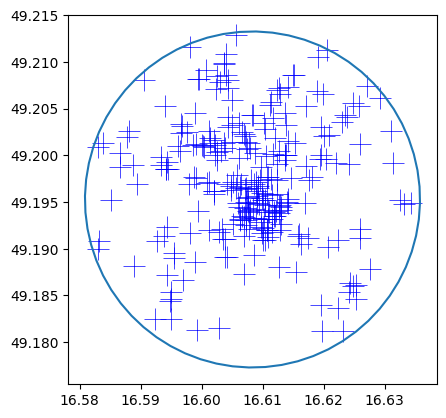

In [9]:
# plot filtered data
# simple plot
ax = poly.boundary.plot()
data_poly.drop_duplicates(subset=['lat','lon']).crd.plot(ax = ax,marker = '+', color = 'blue',markersize = 250,lw = 0.5,)
plt.savefig(f'geo-web-maps/geo-web-demo-plot.pdf',bbox_inches='tight',pad_inches=0)

In [10]:
# map plot
map_fl = folium.Map(location=city_centre,zoom_start=13,width=450,height=450)

# spatial polygon
crds = [(item[1], item[0]) for item in poly[0].exterior.coords] # reverse lat lon
poly_fl = folium.Polygon(locations=crds,color='blue')
poly_fl.add_to(map_fl)   

# sample data
crds = data_poly.drop_duplicates(subset=['lat','lon'],keep='last')
for item in crds.itertuples():
    folium.Marker(
        location=[item.lat,item.lon],
        popup=f'{item.web}, {item.lat}, {item.lon}, {item.city}, {item.country}',
        size=1).add_to(map_fl)

map_fl.save('geo-web-maps/geo-web-demo-interactive.html')
display(HTML(open('geo-web-maps/geo-web-demo-interactive.html').read()))

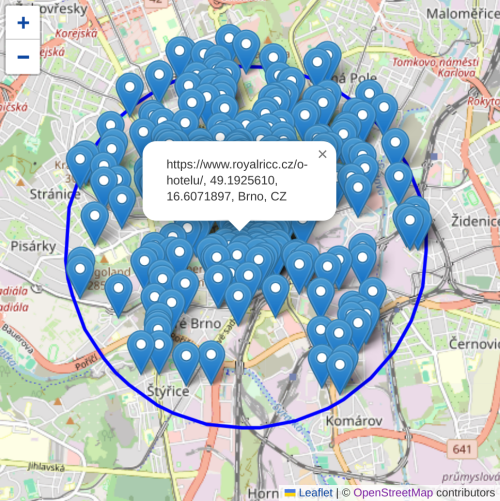

In [11]:
# show interactive map screen
Image('geo-web-maps/geo-web-demo-screen.png')

# Fetch webpage content

In [12]:
# get sample webpage in spatial polygon
geoweb = data_poly.iloc[0]
geoweb.to_dict()

{'web': 'https://www.centrumdvorak.cz/wp-content/themes/MedicalDoctor/css/animate-custom.css?ver=3.7.38',
 'lat': '49.1932205',
 'lon': '16.6108642',
 'city': 'Brno',
 'country': 'CZ',
 'online': '20230117154740',
 'crd': <POINT (16.611 49.193)>}

In [13]:
# construct url to fetch content from Internet Archive
url = f'https://web.archive.org/web/{geoweb['online']}/{geoweb['web']}'
url

'https://web.archive.org/web/20230117154740/https://www.centrumdvorak.cz/wp-content/themes/MedicalDoctor/css/animate-custom.css?ver=3.7.38'

In [14]:
# get content
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

In [15]:
# parse and print content
web_text = soup.get_text()
web_text = ' '.join(web_text.split())
web_text

'\ufeff | centrum-dvorak.cz Zavolejte nám: 542 423 200 Orlí 10, Brno Pro výsledky vyšetření volejte prosím od 10:00 do 15:00 h Ordinace GynekologiePraktičtí lékaři pro děti a dorostPraktičtí lékaři pro dospělé Služby Primární gynekologická péčePrenatální péčeAmbulance onkologické prevenceGynekologické operační zákrokyTerapie laseremUrogynekologieDenzitometrieEstetické výkonyKlinické studiePorodní příprava pro nastávající maminky Náš tým LékařiSestryAdministrativaAktualityKontakty Online objednání Online objednání Naším cílem je poskytovat lékařskou péči citlivě a s respektem k vašim individuálním potřebám. Doufáme, že se o kvalitě našich služeb přesvědčíte sami a staneme se přirozenou volbou pro vaši rodinnou péči. Objednejte se online Ordinace GynekologiePraktičtí lékaři pro děti a dorostPraktičtí lékaři pro dospělé Odkazy Napsali o nás Čím jsme výjimeční GDPR Informované souhlasy Poskytované služby Rychlé kontakty V případě dotazů se na nás neváhejte obrátit, naši zaměstnanci jsou Vá